<a href="https://colab.research.google.com/github/sdrangan/wirelesscomm/blob/master/unit01_antennas/demo_sionna_free_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free Space Propagation with Nvidia's Sionna

[Sionna](https://nvlabs.github.io/sionna/) is a fully open-source Tensorflow-based package developed by Nvidia to support physical layer wireless experiments.  The package does not yet have the same extent of functionality as MATLAB's toolboxes.  However, Sionna supports:

* Full python interface
* Integration with Tensorflow for machine learning
* Integration with ray tracing

In this demo, you will learn to:

* Install sionna and load the package
* Create a simple free-space environment
* Orient transmitters and receievers
* Compute and plot the complex channel gain and delay

## Installation and Getting Started
You can run this demo on Google Colab.  If you run it on your local machine, you will need to [install sionna](https://nvlabs.github.io/sionna/installation.html).  Note you may need to install a [LLVM backend](https://drjit.readthedocs.io/en/latest/what.html#backends).  The following code can be used to import sionna.  On Google Colab, it will install sionna if it is not already installed.

In [1]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    !pip install sionna
    #os.system("pip install sionna")
    import sionna as sn

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

INFO: pip is looking at multiple versions of ipywidgets to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of ipywidgets to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.6/271.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.3/384.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.0 MB/s eta 

We can test if sionna is installed by printing the version

In [2]:
print(sn.__version__)

0.19.1


We can also see if we are using a GPU, although for this demo a CPU is fine.  In fact, a GPU in this case will not even help.

In [3]:
dev = tf.config.list_physical_devices()
print(dev)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


For the wireless class, I will add a few additional utilities that can be used with sionna package.  These are in the `sionnautils` package in the [wireless commununications github](https://github.com/sdrangan/wirelesscomm).  If you are running on your local machine, you should follow the instructions to install the `sionnautils` package.  If you are on Google colab, the code below will automatically install the package, if it is not already installed.

In [11]:
# Import Sionna utils from the wireless class
try:
    import sionnautils
except ImportError as e:
    # Install Sionna if package is not already installed
    !pip install git+https://github.com/sdrangan/wirelesscomm.git
    import sionnautils


We will also import some basic modules

In [13]:
import numpy as np
import matplotlib.pyplot as plt

## Creating a Free-Space Propagation Scene

To simulate free-space propagation, we will create an empty environment.  The environment in Sionna is called a [scene](https://nvlabs.github.io/sionna/api/rt.html#scene).  Scenes are described in part by xml files.  Unfortunately, sionna does not provide an empty scene. So, I have created an empty scene xml that can be loaded with the following command in the `sionnautils` package.


In [23]:
import sionnautils.custom_scene as custom_scene
scene = sn.rt.load_scene(custom_scene.get_scene('empty_scene'))

# Set the scene frequency
fc = 3.5e9
scene.fc = fc

We will place the TX at `(0,0,0)` and receivers at a number of points in a straightline path.

In [14]:
# Set the transmitter position
txpos = np.zeros(3)

# Define the linear RX path
npts = 100;
rxstart = np.array([500,-100, 0])
rxend = np.array([-500, 200, 50])
t = np.linspace(0,1,npts)
rxpos = (1-t[:,None])*rxstart[None,:] + t[:,None]*rxend[None,:]


Create 3D plot of the path

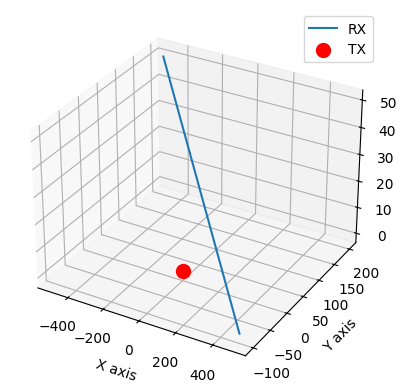

In [15]:
# Creating the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting RX points
ax.plot(rxpos[:, 0], rxpos[:, 1], rxpos[:, 2], label='RX')

# Plotting TX point
ax.scatter(txpos[0], txpos[1], txpos[2], color='red', s=100, label='TX')

# Adding labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Adding legend
ax.legend()

In sionna, we have to specify the antennas.  Sionna has some simple built-in antennas, although the library is not as extensive as MATLAB's antenna toolbox.  In the lab, you will see how to add a custom antenna.  For now we create arrays based on a 3GPP antenna pattern which has about a 65 degree beamwidth.  One odd feature of sionna is that all the TX and RX elements have to have the same array.

In [16]:
# Configure antenna array for all transmitters
scene.tx_array = sn.rt.PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = sn.rt.PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

Next, we add the transmitter and receivers

In [17]:
# Create transmitter
tx = sn.rt.Transmitter(name="tx", position=txpos)

# Add transmitter instance to scene
scene.add(tx)

# Create and add the receivers
for i in range(npts):
  name = 'rx' + str(i)
  rx = sn.rt.Receiver(name=name,
              position=rxpos[i])
  scene.add(rx)

## Orienting the Receivers

By default, the 3GPP antenna pattern is oriented with the bore sight in the x-axis.  To illustrate, let's orient the antennas on the RX in the path direction. For this purpose, we first create a target point in the direction of the path and then orient the receiver to point at the target.

In [18]:
rxtgt = -rxstart + 2*rxend  # Target position = position of RX if time = 2

# Make all RX look at the target
for i in range(npts):
    name = 'rx' + str(i)
    rx = scene.get(name)
    rx.look_at(rxtgt)

## Computing the Propagation Paths

We can compute the complex path gain and delay with the `scene.compute_paths` method.  This method nicely accounts for all the orientations of the TX and RX and polarizations, which simplifies the computations significantly.  From the paths, it computes the discrete channel impulse response with the `paths.cir` method.

In [19]:
# Compute the paths
paths = scene.compute_paths()
paths.normalize_delays = False
a, tau = paths.cir()

If we print the shape of `a` and `tau` we see it is a multi-dimensional tensor.  In general, (see the documentation for the 'paths.cir' method in the [API page](https://nvlabs.github.io/sionna/_modules/sionna/rt/paths.html)), it is of shape:
~~~
    a.shape = [batch_size, num_rx, num_rx_ant, num_tx, num_tx_ant, max_num_paths, num_time_steps]
    tau.shape = [batch_size, num_rx, num_tx, max_num_paths, num_time_steps]
~~~
But in our case only the `num_rx` is not equal to 1.  So, we can eliminate these dimensions with the `squeeze` command.  We will also convert these from tensorflow Tensors to numpy.

In [20]:
print('Full shape of a: ' + str(a.shape))
print('Full shape of tau: ' + str(tau.shape))
a = a.numpy().squeeze()
tau = tau.numpy().squeeze()

Full shape of a: (1, 100, 1, 1, 1, 1, 1)
Full shape of tau: (1, 100, 1, 1)


Let's compare the delay to the expected delay

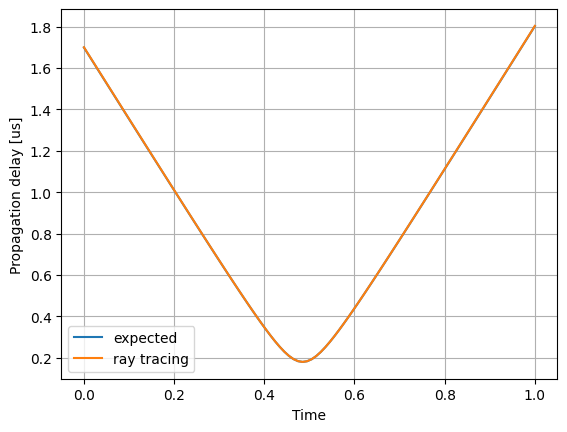

In [21]:
vc = 3e8  # speed of light
dist = np.sqrt(np.sum((rxpos - txpos)**2, axis=1))

tau_est = dist/vc

plt.plot(t, tau_est*1e6, label='expected')
plt.plot(t, tau*1e6, label='ray tracing')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Propagation delay [us]')
plt.legend()

Next, we plot the gain compared to the free space path loss

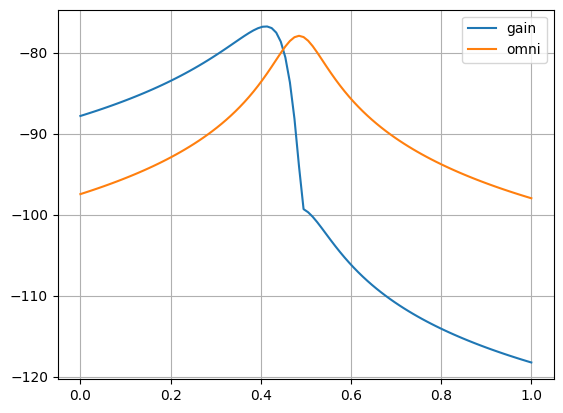

In [24]:
gain = 20*np.log10(np.abs(a))

# Theoretical free space path loss with omni antenna
lam = vc/fc
fspl_omni = 20*np.log10(lam / (4*np.pi*dist))

plt.plot(t, gain, label='gain')
plt.plot(t, fspl_omni, label='omni')
plt.grid()
plt.legend()